In [1]:
import tensorflow as tf
import numpy as np
import gym
from collections import deque
import random
import cv2
import scipy

import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError




In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError



class DeepQNN:
    '''
    episodes - NUMBER OF GAMES
    gamma - discount rate
    epsilon - exploration rate
    epsilon_decay - decrease the number of explorations
    epsilon_min - lower epsilon
    lr - learning rate
    '''
    def __init__(self, env, episodes = 5000 , gamma = 0.95, epsilon = 1, epsilon_decay=0.995, epsilon_min=0.05, lr=0.0001, random_state=42):
    
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lr = lr
        self.random_state = random_state
        self.n_actions = env.action_space.n
        self.env = env
        self.batch_size = 50
        self.episodes = episodes
        self.model_params = None
        
        self.activation_fn = tf.nn.elu
        self.weights_initializer = tf.contrib.layers.variance_scaling_initializer()
        self.optimizer = tf.train.AdamOptimizer
        
        self._graph = None
        self._session = None
        self.training_op = None
        self.model = None
        self.init = None
        self.saver = None
        
        # Memory used for replaying actions
        '''
        using this memory improve stability. NN tends to forget previous actions learned, so the memory
        allows a esxperience replay
        '''
        self.memmory = deque()
        
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
            
        self.build_dnn()
            
    def build_dnn(self):
        #Reset Tensorflow Graph
        tf.reset_default_graph()
        tf.set_random_seed(self.random_state)
        np.random.seed(self.random_state)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            n_conv_filters = 32

            X = tf.placeholder(tf.float32, shape=(None, 160, 100, 1),name= 'state')
            y = tf.placeholder(tf.float32, shape=(None), name='quality')
            self._X, self._y = X, y
            self.training = tf.placeholder_with_default(False, shape=[], name='training')

            conv_one = tf.layers.conv2d(X,filters= 8, kernel_size=5, strides=1,
                                    padding= "SAME", activation= tf.nn.relu, name="conv1"
                                   ,kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            conv_two = tf.layers.conv2d(conv_one,filters= 12, kernel_size=5, strides=1,
                                    padding= "SAME", activation= tf.nn.relu, name="conv2"
                                   ,kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            #conv_three = tf.layers.conv2d(conv_two,filters= 8, kernel_size=5, strides=1,
                                    #padding= "SAME", activation= tf.nn.relu, name="conv3"
                                   #,kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            flat = tf.reshape(conv_two, shape=[-1, 12 * 160 * 100])
            #with tf.name_scope("pool"):
            #    pool = tf.nn.max_pool(conv_two, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
            #   pool_flat = tf.reshape(pool, shape=[-1, n_conv_filters * 32 * 32])

            with tf.name_scope("fc"):
                fc1 = tf.layers.dense(flat, 32, activation=tf.nn.relu, name="fc1"
                                      , kernel_initializer = tf.contrib.layers.xavier_initializer())
                #fc1_dropout = tf.layers.dropout(fc1, 0.5, training = self.training)
                fc2 = tf.layers.dense(fc1, 16, activation=tf.nn.relu,name="fc2"
                                      ,kernel_initializer = tf.contrib.layers.xavier_initializer())
                #fc2_dropout = tf.layers.dropout(fc2, 0.5, training = self.training)
                # Dense with linear activation function
                self.model = tf.layers.dense(fc2, self.n_actions,name="fc3"
                                            ,kernel_initializer = tf.contrib.layers.xavier_initializer())

            with tf.name_scope("train"):
                loss = tf.losses.mean_squared_error(self._y, self.model)
                #loss = tf.reduce_mean(tf.squared_difference(x=self.model,y=self._y))
                optimizer = tf.train.AdamOptimizer(0.001)
                self.training_op = optimizer.minimize(loss, name = "training")

            with tf.name_scope("init_and_save"):
                self.init = tf.global_variables_initializer()
                self.saver = tf.train.Saver()
            
        self._session = tf.Session(graph=self._graph)
       
            
    def remember_transition(self,state, action, reward, new_state, end):
        
        self.memmory.append((state, action, reward, new_state, end))
        
    def minibatch_sample(self):
        return random.sample(self.memmory, self.batch_size)
    
    def predict(self,state):
        with self._session.as_default() as sess:
            return self.model.eval(feed_dict={self._X: state, self.training:False})
    
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_actions)
        predict = self.predict(state)[0]
        return np.argmax(predict)

    def experience_learing(self):

        minibatch = random.sample(self.memmory, self.batch_size)
        for state, action, reward, next_state, end in minibatch:
            target = reward
            if not end:
                target = reward + self.gamma * np.amax(self.predict(next_state)[0])
            target_f = self.predict(state)[0]
            target_f[action] = target         

            with self._session.as_default() as sess:
                sess.run(self.training_op, feed_dict={self._X: state, self._y: target_f, self.training: True})
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        '''
    
        states = self.minibatch_sample()
        inputs = np.zeros((self.batch_size, 64, 64, 1))
        targets = np.zeros((self.batch_size, self.n_actions))
        for i in range(len(states)):
            state = states[i][0]
            action = states[i][1] 
            reward = states[i][2]
            new_state = states[i][3]
            end = states[i][4]
            # Bellman equation
            inputs[i: i+1] = state
            quality = reward + self.gamma * np.amax(self.predict(new_state)[0])
            if end:
                quality = reward
            targets[i] = self.predict(state)
            targets[i][action] = quality
            
        with self._session.as_default() as sess:
            sess.run(self.training_op, feed_dict={self._X: inputs, self._y: targets, self.training: True})
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
                
        '''
    def position(self,pos):
        screen_width = 600
        world_width = 2.4* 2
        scale = screen_width / world_width
        pos = int(pos * scale + screen_width / 2.0)
        return pos
        
    def state_transformation(self, pos, img):
        '''
        state = scipy.misc.imresize(state,(64,64))
        r,g,b = state[:,:,0], state[:,:,1], state[:,:,2]
        bw = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return bw.reshape(1,64,64,1)
        '''
        img = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
        pos = self.position(pos)
        min_pos = pos - 50
        max_pos = pos +50
        if min_pos < 0:
            min_pos = 0
            max_pos = 100
        if max_pos > 600:
            min_pos = 500
            max_pos = 600
       
        img = img[160:320,min_pos:max_pos]
        #img = cv2.resize(img,(64,64)) 
        return img.reshape(1,160,100,1)
        
    
    def get_model_params(self):
        gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

    def restore_model_params(self, model_params):
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign") for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

    
    def train(self):
        interactions = 500
        state_size = self.env.observation_space.shape[0]
        with self._session.as_default() as sess:
            self.init.run()
        end = False
        max_iterations = 0
        for e in range(self.episodes):
            obs = self.env.reset()
            state = self.env.render(mode='rgb_array')
            state = self.state_transformation(obs[0],state)
            next_state = self.env.render(mode='rgb_array')
            next_state = self.state_transformation(0,next_state)
            #diff = state
            for iteration in range(500):
                action = self.select_action(state)  
                obs, reward, end, _ = env.step(action)
                #extra_reward = 1.0/abs(obs[2]) + 1.0/abs(obs[3])
                pix  = self.env.render(mode='rgb_array')
                next_state = self.state_transformation(obs[0],pix)
                #next_diff = next_state - state
                reward = reward #+ extra_reward
                if end:
                    reward = - 10
                self.remember_transition(state, action, reward, next_state, end)
                #diff = next_diff
                state = next_state 
                if end:
                    print("Episode: %d/%d, score: %d" % (e, self.episodes, iteration))
                    if iteration > max_iterations:
                        max_iterations = iteration 
                    break

            if len(self.memmory) > self.batch_size:
                self.experience_learing()
    

        print("Best Number of Iterations: %d" % (max_iterations))
        
        with tf.Session() as sess:
            self.saver.save(sess, "./openai_convolution.ckpt")  
            
    

In [3]:
env = gym.make('CartPole-v1')
q_dnn= DeepQNN(env)

[2017-09-11 00:30:14,577] Making new env: CartPole-v1


In [ ]:
q_dnn.train()

Episode: 0/5000, score: 20
Episode: 1/5000, score: 22
Episode: 2/5000, score: 43
Episode: 3/5000, score: 16
Episode: 4/5000, score: 15
Episode: 5/5000, score: 9
Episode: 6/5000, score: 20
Episode: 7/5000, score: 20
Episode: 8/5000, score: 26
Episode: 9/5000, score: 11
Episode: 10/5000, score: 17
Episode: 11/5000, score: 19
Episode: 12/5000, score: 50
Episode: 13/5000, score: 9
Episode: 14/5000, score: 20
Episode: 15/5000, score: 35
Episode: 16/5000, score: 15
Episode: 17/5000, score: 19
Episode: 18/5000, score: 20
Episode: 19/5000, score: 15
Episode: 20/5000, score: 10
Episode: 21/5000, score: 21
Episode: 22/5000, score: 15
Episode: 23/5000, score: 38
Episode: 24/5000, score: 8
Episode: 25/5000, score: 51
Episode: 26/5000, score: 12
Episode: 27/5000, score: 13
Episode: 28/5000, score: 12
Episode: 29/5000, score: 19
Episode: 30/5000, score: 15
Episode: 31/5000, score: 25
Episode: 32/5000, score: 39
Episode: 33/5000, score: 26
Episode: 34/5000, score: 12
Episode: 35/5000, score: 28
Episo

Episode: 288/5000, score: 10
Episode: 289/5000, score: 11
Episode: 290/5000, score: 13
Episode: 291/5000, score: 30
Episode: 292/5000, score: 30
Episode: 293/5000, score: 22
Episode: 294/5000, score: 13
Episode: 295/5000, score: 32
Episode: 296/5000, score: 9
Episode: 297/5000, score: 8
Episode: 298/5000, score: 9
Episode: 299/5000, score: 9
Episode: 300/5000, score: 68
Episode: 301/5000, score: 14
Episode: 302/5000, score: 8
Episode: 303/5000, score: 36
Episode: 304/5000, score: 9
Episode: 305/5000, score: 9
Episode: 306/5000, score: 20
Episode: 307/5000, score: 13
Episode: 308/5000, score: 16
Episode: 309/5000, score: 10
Episode: 310/5000, score: 33
Episode: 311/5000, score: 11
Episode: 312/5000, score: 22
Episode: 313/5000, score: 13
Episode: 314/5000, score: 19
Episode: 315/5000, score: 10
Episode: 316/5000, score: 41
Episode: 317/5000, score: 13
Episode: 318/5000, score: 19
Episode: 319/5000, score: 36
Episode: 320/5000, score: 9
Episode: 321/5000, score: 11
Episode: 322/5000, sco

Episode: 575/5000, score: 22
Episode: 576/5000, score: 13
Episode: 577/5000, score: 11
Episode: 578/5000, score: 23
Episode: 579/5000, score: 10
Episode: 580/5000, score: 11
Episode: 581/5000, score: 42
Episode: 582/5000, score: 11
Episode: 583/5000, score: 45
Episode: 584/5000, score: 9
Episode: 585/5000, score: 22
Episode: 586/5000, score: 28
Episode: 587/5000, score: 54
Episode: 588/5000, score: 46
Episode: 589/5000, score: 38
Episode: 590/5000, score: 52
Episode: 591/5000, score: 9
Episode: 592/5000, score: 8
Episode: 593/5000, score: 12
Episode: 594/5000, score: 36
Episode: 595/5000, score: 36
Episode: 596/5000, score: 8
Episode: 597/5000, score: 9
Episode: 598/5000, score: 10
Episode: 599/5000, score: 9
Episode: 600/5000, score: 11
Episode: 601/5000, score: 8
Episode: 602/5000, score: 34
Episode: 603/5000, score: 9
Episode: 604/5000, score: 9
Episode: 605/5000, score: 8
Episode: 606/5000, score: 9
Episode: 607/5000, score: 9
Episode: 608/5000, score: 24
Episode: 609/5000, score: 

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError



class QNN:
    '''
    episodes - NUMBER OF GAMES
    gamma - discount rate
    epsilon - exploration rate
    epsilon_decay - decrease the number of explorations
    epsilon_min - lower epsilon
    lr - learning rate
    '''
    def __init__(self, env, episodes = 5000 , gamma = 0.95, epsilon = 1, epsilon_decay=0.995, epsilon_min=0.05, lr=0.001, random_state=42):
    
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lr = lr
        self.random_state = random_state
        self.n_actions = env.action_space.n
        self.env = env
        self.batch_size = 50
        self.episodes = episodes
        self.model_params = None
        
        self.activation_fn = tf.nn.elu
        self.weights_initializer = tf.contrib.layers.variance_scaling_initializer()
        self.optimizer = tf.train.AdamOptimizer
        
        self._graph = None
        self._session = None
        self.training_op = None
        self.model = None
        self.init = None
        self.saver = None
        
        # Memory used for replaying actions
        '''
        using this memory improve stability. NN tends to forget previous actions learned, so the memory
        allows a esxperience replay
        '''
        self.memmory = deque()
        
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
            
        self.build_dnn()
            
    def build_dnn(self):
        #Reset Tensorflow Graph
        tf.reset_default_graph()
        tf.set_random_seed(self.random_state)
        np.random.seed(self.random_state)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            X = tf.placeholder(tf.float32, shape=(None,4),name= 'state')
            y = tf.placeholder(tf.float32, shape=(None), name='quality')
            self._X, self._y = X, y
            self.training = tf.placeholder_with_default(False, shape=[], name='training')

            with tf.name_scope("fc"):
                fc1 = tf.layers.dense(X, 12, activation=tf.nn.relu, name="fc1")
                #fc1_dropout = tf.layers.dropout(fc1, 0.5, training = self.training)
                fc2 = tf.layers.dense(fc1, 12, activation=tf.nn.relu,name="fc2")
                #fc2_dropout = tf.layers.dropout(fc2, 0.5, training = self.training)
                # Dense with linear activation function
                self.model = tf.layers.dense(fc2, self.n_actions,name="fc3")

            with tf.name_scope("train"):
                loss = tf.losses.mean_squared_error(self._y, self.model)
                optimizer = tf.train.AdamOptimizer(0.001)
                self.training_op = optimizer.minimize(loss, name = "training")

            with tf.name_scope("init_and_save"):
                self.init = tf.global_variables_initializer()
                self.saver = tf.train.Saver()
            
        self._session = tf.Session(graph=self._graph)
       
            
    def remember_transition(self,state, action, reward, new_state, end):
        
        self.memmory.append((state, action, reward, new_state, end))
        
    def minibatch_sample(self):
        return random.sample(self.memmory, self.batch_size)
    
    def predict(self,state):
        with self._session.as_default() as sess:
            return self.model.eval(feed_dict={self._X: state.reshape(1,4), self.training:False})
    
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_actions)
        predict = self.predict(state)[0]
        #print('Action ',predict)
        #print('Predicted ',np.argmax(predict))
        return np.argmax(predict)

    def experience_learing(self):
        
        minibatch = random.sample(self.memmory, self.batch_size)
        for state, action, reward, next_state, end in minibatch:
            target = reward
            if not end:
                target = reward + self.gamma * np.amax(self.predict(next_state)[0])
            target_f = self.predict(state)[0]
            target_f[action] = target         

            with self._session.as_default() as sess:
                sess.run(self.training_op, feed_dict={self._X: state.reshape(1,4), self._y: target_f, self.training: True})
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        '''
        states = self.minibatch_sample()
        inputs = np.zeros((self.batch_size,4))
        targets = np.zeros((self.batch_size, self.n_actions))
        for i in range(len(states)):
            state = states[i][0]
            action = states[i][1] 
            reward = states[i][2]
            new_state = states[i][3]
            end = states[i][4]
            # Bellman equation
            inputs[i] = state
            quality = reward + self.gamma * np.amax(self.predict(new_state)[0])
            if end:
                quality = reward
            targets[i] = self.predict(state)
            targets[i][action] = quality
            
        with self._session.as_default() as sess:
            sess.run(self.training_op, feed_dict={self._X: inputs, self._y: targets, self.training: True})
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        '''        
        
         

    
    def get_model_params(self):
        gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

    def restore_model_params(self, model_params):
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign") for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

    
    def train(self):
        interactions = 2000
        state_size = self.env.observation_space.shape[0]
        with self._session.as_default() as sess:
            self.init.run()
        end = False
        max_iterations = 0
        for e in range(self.episodes):
            state = self.env.reset().reshape(1, self.env.observation_space.shape[0])
             
            for iteration in range(interactions):
                action = self.select_action(state) 
                next_state, reward, end, _ = env.step(action)
                #extra_reward = 1.0/abs(next_state[2]) + 1.0/abs(next_state[3])
                reward = reward #+ extra_reward
                self.remember_transition(state, action, reward, next_state, end)
                state = next_state 
                if end:
                    print("Episode: %d/%d, score: %d" % (e, self.episodes, iteration))
                    if iteration > max_iterations:
                        max_iterations = iteration 
                    break

            if len(self.memmory) > self.batch_size:
                self.experience_learing()
    

        print("Best Number of Iterations: %d" % (max_iterations))
        
        with tf.Session() as sess:
            self.saver.save(sess, "./openai.ckpt")  
            
    

In [3]:
env = gym.make('CartPole-v1')
q_dnn= QNN(env)
q_dnn.train()

[2017-09-11 00:24:47,591] Making new env: CartPole-v1


Episode: 0/5000, score: 13
Episode: 1/5000, score: 11
Episode: 2/5000, score: 47
Episode: 3/5000, score: 25
Episode: 4/5000, score: 16
Episode: 5/5000, score: 18
Episode: 6/5000, score: 10
Episode: 7/5000, score: 11
Episode: 8/5000, score: 18
Episode: 9/5000, score: 9
Episode: 10/5000, score: 48
Episode: 11/5000, score: 46
Episode: 12/5000, score: 14
Episode: 13/5000, score: 13
Episode: 14/5000, score: 24
Episode: 15/5000, score: 21
Episode: 16/5000, score: 15
Episode: 17/5000, score: 32
Episode: 18/5000, score: 29
Episode: 19/5000, score: 10
Episode: 20/5000, score: 26
Episode: 21/5000, score: 15
Episode: 22/5000, score: 54
Episode: 23/5000, score: 55
Episode: 24/5000, score: 11
Episode: 25/5000, score: 18
Episode: 26/5000, score: 24
Episode: 27/5000, score: 37
Episode: 28/5000, score: 29
Episode: 29/5000, score: 17
Episode: 30/5000, score: 39
Episode: 31/5000, score: 10
Episode: 32/5000, score: 18
Episode: 33/5000, score: 39
Episode: 34/5000, score: 19
Episode: 35/5000, score: 14
Epi

Episode: 288/5000, score: 70
Episode: 289/5000, score: 33
Episode: 290/5000, score: 89
Episode: 291/5000, score: 30
Episode: 292/5000, score: 43
Episode: 293/5000, score: 34
Episode: 294/5000, score: 29
Episode: 295/5000, score: 65
Episode: 296/5000, score: 59
Episode: 297/5000, score: 42
Episode: 298/5000, score: 42
Episode: 299/5000, score: 73
Episode: 300/5000, score: 185
Episode: 301/5000, score: 102
Episode: 302/5000, score: 48
Episode: 303/5000, score: 32
Episode: 304/5000, score: 42
Episode: 305/5000, score: 156
Episode: 306/5000, score: 51
Episode: 307/5000, score: 52
Episode: 308/5000, score: 81
Episode: 309/5000, score: 147
Episode: 310/5000, score: 40
Episode: 311/5000, score: 43
Episode: 312/5000, score: 50
Episode: 313/5000, score: 23
Episode: 314/5000, score: 43
Episode: 315/5000, score: 39
Episode: 316/5000, score: 43
Episode: 317/5000, score: 123
Episode: 318/5000, score: 66
Episode: 319/5000, score: 51
Episode: 320/5000, score: 57
Episode: 321/5000, score: 40
Episode: 

Episode: 567/5000, score: 157
Episode: 568/5000, score: 194
Episode: 569/5000, score: 147
Episode: 570/5000, score: 209
Episode: 571/5000, score: 146
Episode: 572/5000, score: 144
Episode: 573/5000, score: 144
Episode: 574/5000, score: 139
Episode: 575/5000, score: 225
Episode: 576/5000, score: 136
Episode: 577/5000, score: 132
Episode: 578/5000, score: 146
Episode: 579/5000, score: 156
Episode: 580/5000, score: 307
Episode: 581/5000, score: 124
Episode: 582/5000, score: 115
Episode: 583/5000, score: 140
Episode: 584/5000, score: 129
Episode: 585/5000, score: 130
Episode: 586/5000, score: 124
Episode: 587/5000, score: 128
Episode: 588/5000, score: 151
Episode: 589/5000, score: 180
Episode: 590/5000, score: 131
Episode: 591/5000, score: 142
Episode: 592/5000, score: 129
Episode: 593/5000, score: 292
Episode: 594/5000, score: 178
Episode: 595/5000, score: 125
Episode: 596/5000, score: 190
Episode: 597/5000, score: 111
Episode: 598/5000, score: 119
Episode: 599/5000, score: 119
Episode: 6

Episode: 842/5000, score: 173
Episode: 843/5000, score: 146
Episode: 844/5000, score: 220
Episode: 845/5000, score: 144
Episode: 846/5000, score: 168
Episode: 847/5000, score: 135
Episode: 848/5000, score: 151
Episode: 849/5000, score: 145
Episode: 850/5000, score: 132
Episode: 851/5000, score: 119
Episode: 852/5000, score: 146
Episode: 853/5000, score: 140
Episode: 854/5000, score: 125
Episode: 855/5000, score: 130
Episode: 856/5000, score: 285
Episode: 857/5000, score: 277
Episode: 858/5000, score: 499
Episode: 859/5000, score: 236
Episode: 860/5000, score: 251
Episode: 861/5000, score: 222
Episode: 862/5000, score: 232
Episode: 863/5000, score: 190
Episode: 864/5000, score: 499
Episode: 865/5000, score: 499
Episode: 866/5000, score: 183
Episode: 867/5000, score: 160
Episode: 868/5000, score: 230
Episode: 869/5000, score: 258
Episode: 870/5000, score: 274
Episode: 871/5000, score: 208
Episode: 872/5000, score: 148
Episode: 873/5000, score: 185
Episode: 874/5000, score: 265
Episode: 8

Episode: 1113/5000, score: 149
Episode: 1114/5000, score: 149
Episode: 1115/5000, score: 249
Episode: 1116/5000, score: 277
Episode: 1117/5000, score: 164
Episode: 1118/5000, score: 206
Episode: 1119/5000, score: 203
Episode: 1120/5000, score: 164
Episode: 1121/5000, score: 181
Episode: 1122/5000, score: 455
Episode: 1123/5000, score: 499
Episode: 1124/5000, score: 265
Episode: 1125/5000, score: 364
Episode: 1126/5000, score: 149
Episode: 1127/5000, score: 176
Episode: 1128/5000, score: 267
Episode: 1129/5000, score: 136
Episode: 1130/5000, score: 186
Episode: 1131/5000, score: 160
Episode: 1132/5000, score: 131
Episode: 1133/5000, score: 123
Episode: 1134/5000, score: 133
Episode: 1135/5000, score: 151
Episode: 1136/5000, score: 145
Episode: 1137/5000, score: 149
Episode: 1138/5000, score: 146
Episode: 1139/5000, score: 229
Episode: 1140/5000, score: 194
Episode: 1141/5000, score: 162
Episode: 1142/5000, score: 173
Episode: 1143/5000, score: 186
Episode: 1144/5000, score: 128
Episode:

Episode: 1379/5000, score: 242
Episode: 1380/5000, score: 135
Episode: 1381/5000, score: 167
Episode: 1382/5000, score: 136
Episode: 1383/5000, score: 166
Episode: 1384/5000, score: 139
Episode: 1385/5000, score: 150
Episode: 1386/5000, score: 150
Episode: 1387/5000, score: 433
Episode: 1388/5000, score: 278
Episode: 1389/5000, score: 401
Episode: 1390/5000, score: 174
Episode: 1391/5000, score: 174
Episode: 1392/5000, score: 133
Episode: 1393/5000, score: 148
Episode: 1394/5000, score: 144
Episode: 1395/5000, score: 204
Episode: 1396/5000, score: 127
Episode: 1397/5000, score: 213
Episode: 1398/5000, score: 214
Episode: 1399/5000, score: 430
Episode: 1400/5000, score: 299
Episode: 1401/5000, score: 110
Episode: 1402/5000, score: 151
Episode: 1403/5000, score: 125
Episode: 1404/5000, score: 143
Episode: 1405/5000, score: 118
Episode: 1406/5000, score: 158
Episode: 1407/5000, score: 131
Episode: 1408/5000, score: 270
Episode: 1409/5000, score: 177
Episode: 1410/5000, score: 124
Episode:

Episode: 1644/5000, score: 131
Episode: 1645/5000, score: 131
Episode: 1646/5000, score: 158
Episode: 1647/5000, score: 153
Episode: 1648/5000, score: 268
Episode: 1649/5000, score: 155
Episode: 1650/5000, score: 224
Episode: 1651/5000, score: 227
Episode: 1652/5000, score: 178
Episode: 1653/5000, score: 214
Episode: 1654/5000, score: 268
Episode: 1655/5000, score: 192
Episode: 1656/5000, score: 136
Episode: 1657/5000, score: 131
Episode: 1658/5000, score: 174
Episode: 1659/5000, score: 170
Episode: 1660/5000, score: 258
Episode: 1661/5000, score: 133
Episode: 1662/5000, score: 191
Episode: 1663/5000, score: 167
Episode: 1664/5000, score: 129
Episode: 1665/5000, score: 131
Episode: 1666/5000, score: 186
Episode: 1667/5000, score: 108
Episode: 1668/5000, score: 260
Episode: 1669/5000, score: 298
Episode: 1670/5000, score: 170
Episode: 1671/5000, score: 246
Episode: 1672/5000, score: 366
Episode: 1673/5000, score: 400
Episode: 1674/5000, score: 244
Episode: 1675/5000, score: 212
Episode:

KeyboardInterrupt: 

In [2]:
env = gym.make('CartPole-v1')
print(env.reset())
state, reward, end, _ = env.step(0)
img = env.render(mode='rgb_array')


[2017-09-11 00:15:10,011] Making new env: CartPole-v1


[-0.01779243  0.04391646 -0.0282028   0.00472075]


In [3]:
state

array([-0.0169141 , -0.15078991, -0.02810838,  0.28837364])

In [4]:
print(img.shape)

(400, 600, 3)


In [5]:
def position(state):
    screen_width = 600
    world_width = 2.4* 2
    scale = screen_width / world_width
    pos = int(state[0] * scale + screen_width / 2.0)
    return pos

(160, 100)


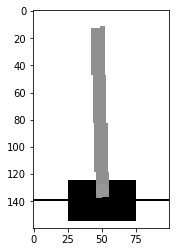

In [10]:
import matplotlib.pyplot as plt
plt.figure()
pos = position(state)
new_img = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
new_img = new_img[160:320,pos-50:pos+50]
#new_img = cv2.resize(new_img,(64,64))
plt.imshow(new_img, cmap='gray')
print(new_img.shape)
plt.show()

In [7]:
state_two, reward, end, _ = env.step(0)
img_two = env.render(mode='rgb_array')

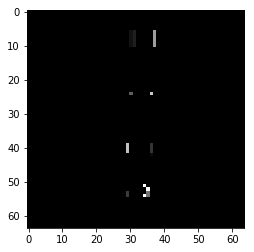

In [8]:
plt.figure()
pos = position(state)
new_img_two = cv2.cvtColor(np.asarray(img_two), cv2.COLOR_BGR2GRAY)
new_img_two = new_img_two[160:320,pos-50:pos+50]
new_img_two = cv2.resize(new_img_two,(64,64))
plt.imshow(new_img_two-new_img, cmap='gray')

plt.show()